<a href="https://colab.research.google.com/github/Bryan-Az/ClusteringMethod-Slate/blob/main/Gaussian_MM_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Clustering by Gaussian Mixture Models
For this notebook and clustering assignment, I will be re-using the actors_meta_df.csv used in the K-Means notebook as it is containing emotional speech data having many dimensions that when clustered together may benefit more from the Gaussian Mixture Model for clustering rather than K-Means clustering. 

# Data Loading

In [16]:
actors_meta_df = pd.read_csv('./data_samples/actors_meta_df.csv')

In [17]:
actors_meta_df.columns

Index(['actor', 'tempo', 'y', 'sr', 'onset_env', 'spectral_centroid',
       'spectral_bandwidth', 'spectral_rolloff', 'zero_crossing_rate',
       'chroma_stft', 'mfcc', 'rmse', 'modality', 'vocal_channel', 'emotion',
       'emotional_intensity', 'statement', 'repetition'],
      dtype='object')

In [18]:
numerical_df = actors_meta_df.loc[:, ['modality', 'vocal_channel', 'emotion',
       'emotional_intensity', 'statement', 'repetition']]

In [19]:
numerical_df.head()

,modality,vocal_channel,emotion,emotional_intensity,statement,repetition
0,3,1,1,1,2,2
1,3,1,2,1,2,1
2,3,1,2,2,1,1
3,3,1,3,1,1,2
4,3,1,3,2,2,2


# Data Pre-Processing

In [20]:
# applying the standard scaler to the numerical data
scaler = StandardScaler()
scaler.fit(numerical_df)
scaled_df = scaler.transform(numerical_df)
scaled_df = pd.DataFrame(scaled_df, columns=numerical_df.columns)
scaled_df.head()

,modality,vocal_channel,emotion,emotional_intensity,statement,repetition
0,0.0,0.0,-1.716790,-0.935414,1.0,1.0
1,0.0,0.0,-1.256936,-0.935414,1.0,-1.0
2,0.0,0.0,-1.256936,1.069045,-1.0,-1.0
3,0.0,0.0,-0.797081,-0.935414,-1.0,1.0
4,0.0,0.0,-0.797081,1.069045,1.0,1.0


In [21]:
scaled_df.describe()

,modality,vocal_channel,emotion,emotional_intensity,statement,repetition
count,1440.0,1440.0,1.440000e+03,1.440000e+03,1440.000000,1440.000000
mean,0.0,0.0,-9.868649e-18,2.540406e-16,0.000000,0.000000
std,0.0,0.0,1.000347e+00,1.000347e+00,1.000347,1.000347
min,0.0,0.0,-1.716790e+00,-9.354143e-01,-1.000000,-1.000000
25%,0.0,0.0,-7.970811e-01,-9.354143e-01,-1.000000,-1.000000
50%,0.0,0.0,1.226279e-01,-9.354143e-01,0.000000,0.000000
75%,0.0,0.0,1.042337e+00,1.069045e+00,1.000000,1.000000
max,0.0,0.0,1.502191e+00,1.069045e+00,1.000000,1.000000


After scaling, it seems that modality and vocal_channel lack sufficient variance to scale properly and therefore the values have all been scaled to 0 across all values. To preserve interpretability we will just drop these columns (scaled data performs better overall) & re-attempt the analysis, adding a new column from the source data.

In [22]:
scaled_df_interpretable = scaled_df.loc[:, ['emotion', 'emotional_intensity', 'statement', 'repetition']]
scaled_df_interpretable.head()

,emotion,emotional_intensity,statement,repetition
0,-1.716790,-0.935414,1.0,1.0
1,-1.256936,-0.935414,1.0,-1.0
2,-1.256936,1.069045,-1.0,-1.0
3,-0.797081,-0.935414,-1.0,1.0
4,-0.797081,1.069045,1.0,1.0


In [23]:
actors_meta_df.tempo.describe()


count    1440.000000
mean      125.635374
std        41.601913
min        46.981534
25%        92.285156
50%       123.046875
75%       151.999081
max       258.398438
Name: tempo, dtype: float64

In [24]:
# fit the standard scaler
scaler = StandardScaler()
scaled_tempo = actors_meta_df.tempo.values.reshape(-1, 1)
scaler.fit(scaled_tempo)
scaled_df_interpretable['tempo'] = scaler.transform(scaled_tempo)

In [25]:
scaled_df_interpretable.tempo.describe()

count    1.440000e+03
mean    -1.554312e-16
std      1.000347e+00
min     -1.891287e+00
25%     -8.019296e-01
50%     -6.224228e-02
75%      6.339340e-01
max      3.192382e+00
Name: tempo, dtype: float64

# Exploratory Data Analysis & Visualization

In [26]:
# applying PCA to the scaled data
pca = PCA(n_components=2)
pca.fit(scaled_df_interpretable)
pca_df = pca.transform(scaled_df_interpretable)
pca_df = pd.DataFrame(pca_df, columns=['PC1', 'PC2'])
pca_df.head()

,PC1,PC2
0,1.929035,-0.409483
1,1.646587,-1.482976
2,0.149863,-0.083424
3,1.149331,1.357508
4,-0.093402,-0.930054


In [27]:
pca_df.shape

(1440, 2)

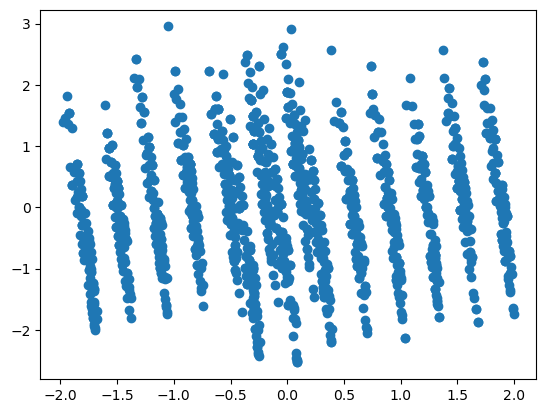

In [28]:
# plotting the pca
plt.scatter(pca_df['PC1'], pca_df['PC2'])

# Clustering 
Using Sklearn's Gaussian Mix Model on the pca_df features we created using the scaled audio features 'emotion', 'emotional_intensity', 'statement', 'repetition' and 'tempo'

In [15]:
# fitting the gaussian mixture model
gmm = GaussianMixture(n_components=4)
gmm.fit(pca_df)
gmm_labels = gmm.predict(pca_df)
pca_df['gmm_labels'] = gmm_labels


: 

In [ ]:
# plot the pca_df using the labels from the gmm
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=gmm_labels)